In [1]:
import geopy
from geopy.geocoders import Nominatim
import plotly.graph_objects as go

import numpy as np
import pandas as pd
import time
import requests
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt

from bs4 import BeautifulSoup

import os
import re

## Загрузка координат и расстояний

In [ ]:
def get_distance_old(coord_1, coord_2):
    link = 'https://yandex.ru/maps/213/moscow/?ll=' + str(coord_1[0]) +'%2C' + str(coord_1[1]) \
            + '&mode=routes&rtext=' + str(coord_1[0]) + '%2C' + str(coord_1[1]) \
            + '~' + str(coord_2[0]) + '%2C' + str(coord_2[1]) + '&rtm=atm&rtt=auto'
    r = requests.get(link)
    
    left = r.text.find('auto-route-snippet-view__route-subtitle')
    s = r.text[left + 40:]
    left = s.find('auto-route-snippet-view__route-subtitle')
    s = s[left + 41:]
    right = s.find('<')
    distance = float(s[:right-2].split('\xa0')[0].replace(',', '.'))
    
    left = r.text.find('auto-route-snippet-view__route-title-primary')
    s = r.text[left + 44:]
    left = s.find('auto-route-snippet-view__route-title-primary')
    s = s[left + 46:]
    right = s.find('<')
    t = s[:right].split(' ')
    if len(t) > 1:
        if '\xa0' in t[0] and '\xa0' in t[1]:
            hours = 60*float(t[0].split('\xa0')[0])
            minutes = float(t[1].split('\xa0')[0])
            time = hours + minutes
        else:
            if t[1] == 'мин':
                time = float(t[0])
            elif t[1] == 'ч':
                time = 60*float(t[0])
    else:
        if t[0].split('\xa0')[1] == 'ч':
            time = 60*float(t[0].split('\xa0')[0])
        else:
            time = float(t[0].split('\xa0')[0])
    return distance, time


def get_distance_new(coord_1, coord_2):
    link = 'https://yandex.ru/maps/213/moscow/?ll=' + str(coord_1[0]) +'%2C' + str(coord_1[1]) \
            + '&mode=routes&rtext=' + str(coord_1[0]) + '%2C' + str(coord_1[1]) \
            + '~' + str(coord_2[0]) + '%2C' + str(coord_2[1]) + '&rtm=atm&rtt=auto'
    r = requests.get(link)

    soup = BeautifulSoup(r.text, 'html.parser')
    time = soup.find_all(attrs={"class": "auto-route-snippet-view__route-title-primary"})[0]
    distance = soup.find_all(attrs={"class": "auto-route-snippet-view__route-subtitle"})[0]
    
    return distance, time

In [199]:
app = Nominatim(user_agent="my-application")

In [238]:
app.geocode('Алматы, Наурызбайский район, Таргап 82')

Location(82, Таргап (Наурызбайский), Шугыла микрорайон, Наурызбайский район, Алматы, A10H6G1, Қазақстан, (43.22187935, 76.79263714999999, 0.0))

In [ ]:
app.geocode('Kazakhstan, Almati, Batyra street, 279')

In [209]:
app.geocode('279, улица Богенбай Батыра, Алмалинский район, Алматы, 050046, Қазақстан')

Location(279, улица Богенбай Батыра, Алмалинский район, Алматы, 050046, Қазақстан, (43.2500791, 76.89536817531945, 0.0))

In [207]:
app.geocode('Казахстан, Алмыты, улица Богенбай Батыра, 279')

In [ ]:
df = pd.read_excel('./data/parsed_data/Moscow_districts.xlsx')
districts = list(df.loc[:, 'District'])

In [4]:
company_list = \
[
    'Ozon',
    'Ozon box',
    'Boxberry',
    'Wildberries',
    'Pickpoint',
    'Макдональдс',
    'KFC',
    'Burger king',
    'CDEK'
]

In [ ]:
d = {}
for company in company_list:
    d[company] = {}
    for district in districts:
        print(company, district)
        time.sleep(1)
        flag = True
        i = 1
        while flag:
            if i > 1:
                print('try number: ' + str(i))
            try:
                location = app.geocode(company + ', Москва, ' + district, exactly_one=False, limit=400)
                flag = False
            except:
                i = i + 1
        if not location is None:
            ads = list(map(lambda x: x[1], location))
        else:
            ads = []
        d[company][district] = ads

In [ ]:
company_ads = {}
for company in company_list:
    company_ads[company] = []
    for value in list(d[company].values()):
        company_ads[company] += value

In [ ]:
f = open('coords_dict.pkl', 'wb')

pickle.dump(company_ads, f)

f.close()

In [ ]:
company_ads

In [2]:
f = open('./data/parsed_data/coords_dict.pkl', 'rb')

company_ads = pickle.load(f)

f.close()

In [5]:
all_points = []
for company in company_list:
    if company != 'Burger King':
        all_points += company_ads[company]
    
all_points = np.array(all_points)

In [26]:
min_x = all_points[:, 0].min()
min_y = all_points[:, 1].min()
all_points[:, 0] = all_points[:, 0] - min_x
all_points[:, 1] = all_points[:, 1] - min_y
all_points = all_points[all_points[:, 1] < 20]
max_x = all_points[:, 0].max()
max_y = all_points[:, 1].max()

In [33]:
delievery = [ 'Ozon',
    'Ozon box',
    'Boxberry',
    'Wildberries',
    'Pickpoint',]

fast_food = [    'Макдональдс',
    'KFC',
    'Burger king',]

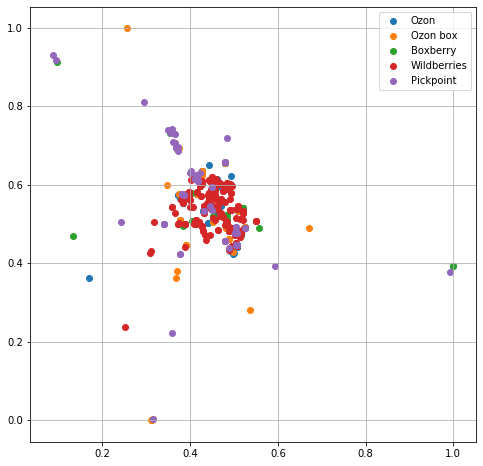

In [39]:
fig = plt.figure(figsize=(8,8))
for company in delievery:
    data = (np.array(company_ads[company]))
    data[:, 0] = data[:, 0] - min_x
    data[:, 1] = data[:, 1] - min_y
    data = data[data[:, 1] < 20]
    data[:, 0] = data[:, 0]/max_x
    data[:, 1] = data[:, 1]/max_y
    plt.scatter(data[:, 0], data[:, 1])
plt.legend(delievery)
plt.grid()
plt.savefig('delievery.jpg')

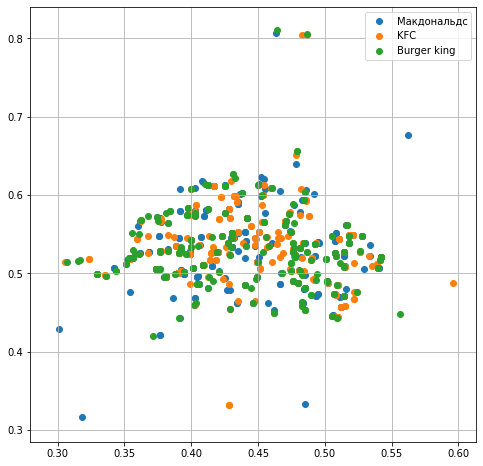

In [38]:
fig = plt.figure(figsize=(8,8))
for company in fast_food:
    data = (np.array(company_ads[company]))
    data[:, 0] = data[:, 0] - min_x
    data[:, 1] = data[:, 1] - min_y
    data = data[data[:, 1] < 20]
    data[:, 0] = data[:, 0]/max_x
    data[:, 1] = data[:, 1]/max_y
    plt.scatter(data[:, 0], data[:, 1])
plt.legend(fast_food)
plt.grid()
plt.savefig('fast_food.jpg')

In [ ]:
temp = np.array(company_ads['Ozon'])

In [ ]:
s = 0
for i in range(len(temp[:, 0])):
    print(i, ((temp[i, 0] == temp[:, 0]) & (temp[i, 1] == temp[:, 1])).sum() - 1)
    s += ((temp[i, 0] == temp[:, 0]) & (temp[i, 1] == temp[:, 1])).sum() - 1 > 0

In [ ]:
s

In [ ]:
long_max = 56.2164
long_min = 55.2829
lat_max = 38.5774
lat_min = 36.7734

In [ ]:
moscow_map = plt.imread('map.png')

In [ ]:
fig, ax = plt.subplots(figsize = (14,14))
plt.imshow(moscow_map)

In [ ]:
BBox = [long_min, long_max, lat_min, lat_max]

In [ ]:
fig, ax = plt.subplots(figsize = (14,14))
ax.scatter(np.array(company_ads['Ozon'])[:, 0], np.array(company_ads['Ozon'])[:, 1], zorder=1, c='b', s=10)

#ax.set_title('Plotting Spatial Data on Moscow Map')
ax.set_xlim(long_min,long_max)
ax.set_ylim(lat_min,lat_max)
#plt.imshow(moscow_map, zorder=0, extent=BBox, aspect= 'equal')


In [ ]:
distances = {}

In [ ]:
for i in range(len(company_list)):
    distance_matrix = np.zeros((len(company_ads[company_list[i]]), 
                                len(company_ads[company_list[i]]),
                                2))
    print(company_list[i])
    for j in tqdm(range(len(list(company_ads.values())[i])), leave=False):
        for k in range(j+1, len(list(company_ads.values())[i])):
            flag = True
            m = 1
            while flag:
                if m > 1:
                    print('try number: ' + str(m))
                try:
                    time.sleep(1)
                    coord_1 = list(company_ads.values())[i][j]
                    coord_2 = list(company_ads.values())[i][k]
                    distance_matrix[j,k,0], distance_matrix[j,k,1] = get_distance(coord_1, coord_2)
                    flag = False
                except KeyboardInterrupt:
                    print(1/0)
                except:
                    m = m + 1
    distances[company_list[i]] = distance_matrix

In [8]:
company_ads['Ozon'][0]

(55.23326445, 37.112215913929916)

In [185]:
coord_1 = company_ads['Ozon'][8]
coord_2 = company_ads['Ozon'][80]
print(coord_1, coord_2)

(55.7288079, 37.5239825) (55.7018714, 37.8405985)


In [ ]:
link = 'https://yandex.ru/maps/213/moscow/?ll=' + str(coord_1[0]) +'%2C' + str(coord_1[1]) \
        + '&mode=routes&rtext=' + str(coord_1[0]) + '%2C' + str(coord_1[1]) \
        + '~' + str(coord_2[0]) + '%2C' + str(coord_2[1]) + '&rtm=atm&rtt=auto'
print(link)
#link='https://yandex.ru/maps/213/moscow/?ll=37.696199%2C55.779150&mode=routes&rtext=55.779118%2C37.692137~55.779773%2C37.693587&rtm=atm&rtt=auto'
#print(link)

r = requests.get(link)
soup = BeautifulSoup(r.text, 'html.parser')

In [194]:
for i, c in enumerate(soup.body.div.div.next_sibling.children):
    if i == 2:
        child = c

for i, c in enumerate(child.div.div.div.div.div.div.div.div):
    print(i, c)
    if i == 0:
        child2 = c

for i, c in enumerate(child2.children):
    print(i, c)
    if i == 1:
        child3 = c

for i, c in enumerate(child3.div):
    print(i, c)
    if i == 3:
        child4 = c
    
print('время: ', child4.div.div.div.div.text)
print('расстояние: ', child4.div.div.div.next_sibling.text.split(',')[0])

0 <div class="ghbpl__edafad"><div class="route-panel-form-view__top-pane"><form action="/" class="route-form-view"><div class="route-travel-modes-view"><div class="route-travel-modes-view__mode _mode_comparison"><div class="route-travel-modes-view__comparison-button"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span><span class="route-travel-modes-view__comparison-button-text">Все</span></div></div><div class="route-travel-modes-view__mode _mode_auto _checked"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span></div><div class="route-travel-modes-view__mode _mode_masstransit"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span></div><div class="route-travel-modes-view__mode _mode_pedestrian"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span></div><div class="route-travel-modes-view__mode _mode_bicycl

In [197]:
soup.find_all(attrs={"class": "auto-route-snippet-view__route-title-primary"})

soup.find_all(attrs={"class": "auto-route-snippet-view__route-subtitle"})

[<div class="auto-route-snippet-view__route-title-primary">33 мин</div>,
 <div class="auto-route-snippet-view__route-title-primary">34 мин</div>,
 <div class="auto-route-snippet-view__route-title-primary">35 мин</div>]

In [195]:
child4

<div class="route-list-view__list"><div class="route-snippet-view _active _type_auto"><div class="auto-route-snippet-view"><div class="auto-route-snippet-view__route-title"><div class="auto-route-snippet-view__route-title-primary">33 мин</div><div class="auto-route-snippet-view__hints"><div class="auto-route-snippet-view__arrival">Прибытие в 19:59</div></div></div><div class="auto-route-snippet-view__route-subtitle">25 км, <span class="auto-route-snippet-view__excluding-traffic">Без учета пробок</span></div><div class="auto-route-snippet-view__links"><div class="auto-route-snippet-view__show-details">Посмотреть подробнее</div><div class="route-snippet-feedback-button-view">Исправить<span class="inline-image route-snippet-feedback-button-view__icon" style="font-size:0;line-height:0"></span></div></div></div></div><div class="route-snippet-view _type_auto"><div class="auto-route-snippet-view"><div class="auto-route-snippet-view__route-title"><div class="auto-route-snippet-view__route-tit

In [175]:
for i, c in enumerate(child.div.div.div.div.div.div.div.div):
    print(i, c)

0 <div class="qx__aaaedcabed"><div class="route-panel-form-view__top-pane"><form action="/" class="route-form-view"><div class="route-travel-modes-view"><div class="route-travel-modes-view__mode _mode_comparison"><div class="route-travel-modes-view__comparison-button"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span><span class="route-travel-modes-view__comparison-button-text">Все</span></div></div><div class="route-travel-modes-view__mode _mode_auto _checked"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span></div><div class="route-travel-modes-view__mode _mode_masstransit"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span></div><div class="route-travel-modes-view__mode _mode_pedestrian"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span></div><div class="route-travel-modes-view__mode _mode_bicyc

In [173]:
child.div.div.div.div.div.div.div.div

<div class="eou__bdbddbacfa"><div class="qx__aaaedcabed"><div class="route-panel-form-view__top-pane"><form action="/" class="route-form-view"><div class="route-travel-modes-view"><div class="route-travel-modes-view__mode _mode_comparison"><div class="route-travel-modes-view__comparison-button"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span><span class="route-travel-modes-view__comparison-button-text">Все</span></div></div><div class="route-travel-modes-view__mode _mode_auto _checked"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span></div><div class="route-travel-modes-view__mode _mode_masstransit"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span></div><div class="route-travel-modes-view__mode _mode_pedestrian"><span class="inline-image route-travel-modes-view__icon" style="font-size:0;line-height:0"></span></div><div class="route-travel-m

In [143]:
 # время

30 мин


28 км


In [ ]:
f = open('distances.pkl', 'wb')

pickle.dump(distances, f)

f.close()

## Формирование датасетов

In [ ]:
f = open('distances.pkl', 'rb')

distances = pickle.load(f)

f.close()

In [ ]:
companies = list(distances.keys())
companies.remove('CDEK')

In [ ]:
final_points = []
final_distances = []
for c in companies:
    n = distances[c].shape[0]
    counter = 0
    ind = []
    for i in range(n):
        if distances[c][i].max() > 200:
            counter = counter + 1
        else:
            ind.append(i)
    ind = np.array(ind)
    final_points.append(np.array(company_ads[c])[ind])
    d = distances[c][np.ix_(ind, ind)]
    for i in range(n-counter):
        for j in range(i + 1, n-counter):
            d[j][i] = d[i][j]
    final_distances.append(d)
    print(c, n - counter)

In [ ]:
point_set = []
dists_set = []
for i in range(len(final_points)):
    r = np.arange(len(final_points[i]))
    if companies[i] == 'Boxberry':
        continue
    for t in range(T):
        ind = np.random.choice(r, size=(50,), replace=False).astype(int)
        points = final_points[i][ind]
        min_x = points[:, 0].min()
        min_y = points[:, 1].min()
        points[:, 0] = points[:, 0] - min_x
        points[:, 1] = points[:, 1] - min_y
        max_x = points[:, 0].max()
        max_y = points[:, 1].max()
        points[:, 0] = points[:, 0]/max_x
        points[:, 1] = points[:, 1]/max_y
        dists = final_distances[i][np.ix_(ind, ind)]
        point_set.append(points)
        dists_set.append(dists)

In [ ]:
f = open('./data/parsed_data/dataset_50.pkl', 'wb')

pickle.dump(point_set, f)

f.close()

f = open('./data/parsed_data/dataset_dist_50.pkl', 'wb')

pickle.dump(dists_set, f)

f.close()

In [ ]:
point_set = []
dists_set = []
for i in range(len(final_points)):
    r = np.arange(len(final_points[i]))
    for t in range(T):
        ind = np.random.choice(r, size=(20,), replace=False).astype(int)
        points = final_points[i][ind]
        min_x = points[:, 0].min()
        min_y = points[:, 1].min()
        points[:, 0] = points[:, 0] - min_x
        points[:, 1] = points[:, 1] - min_y
        max_x = points[:, 0].max()
        max_y = points[:, 1].max()
        points[:, 0] = points[:, 0]/max_x
        points[:, 1] = points[:, 1]/max_y
        dists = final_distances[i][np.ix_(ind, ind)]
        point_set.append(points)
        dists_set.append(dists)

In [ ]:
f = open('./data/parsed_data/dataset_20.pkl', 'wb')

pickle.dump(point_set, f)

f.close()

f = open('./data/parsed_data/dataset_dist_20.pkl', 'wb')

pickle.dump(dists_set, f)

f.close()

## CVRP Instances

In [15]:
dirs = ['A-VRP', 'B-VRP', 'CE-VRP', 'F-VRP', 'P-VRP', 'TSPLIB']
path = 'd:/arseniy/studies/sci/cmc6/data/cvrp/'

In [47]:
data = {}
for directory in dirs:
    cur_path = path + directory
    files = os.listdir(cur_path)
    instances = []
    for file in files:
        instance = {}
        f = open(cur_path + '/' + file, 'r')
        i = 0
        node_coord_flag = 0
        demand_flag = 0
        coords = []
        demand = []
        for row in f:
            if i == 0:
                instance['Name'] = row.split(':')[1].strip()
            elif i == 5:
                print(file)
                instance['Capacity'] = int(row.split(':')[1])
            else:
                if node_coord_flag and not ('DEMAND_SECTION' in row):
                    coords.append((int(float(re.sub(' +', ' ', row.strip()).split(' ')[1])),\
                                   int(float(re.sub(' +', ' ', row.strip()).split(' ')[2]))))
                if 'NODE_COORD_SECTION' in row:
                    node_coord_flag = 1
                if demand_flag and not ('DEPOT_SECTION' in row):
                    demand.append(int(row.strip().split(' ')[1]))
                if 'DEMAND_SECTION' in row:
                    node_coord_flag = 0
                    demand_flag = 1
                if 'DEPOT_SECTION' in row:
                    break
            i = i + 1
        f.close()
        instance['Coords'] = coords
        instance['Demand'] = demand
        instances.append(instance)
    data[directory] = instances

A-n32-k5.vrp
A-n33-k5.vrp
A-n33-k6.vrp
A-n34-k5.vrp
A-n36-k5.vrp
A-n37-k5.vrp
A-n37-k6.vrp
A-n38-k5.vrp
A-n39-k5.vrp
A-n39-k6.vrp
A-n44-k7.vrp
A-n45-k6.vrp
A-n45-k7.vrp
A-n46-k7.vrp
A-n48-k7.vrp
A-n53-k7.vrp
A-n54-k7.vrp
A-n55-k9.vrp
A-n60-k9.vrp
A-n61-k9.vrp
A-n62-k8.vrp
A-n63-k10.vrp
A-n63-k9.vrp
A-n64-k9.vrp
A-n65-k9.vrp
A-n69-k9.vrp
A-n80-k10.vrp
B-n31-k5.vrp
B-n34-k5.vrp
B-n35-k5.vrp
B-n38-k6.vrp
B-n39-k5.vrp
B-n41-k6.vrp
B-n43-k6.vrp
B-n44-k7.vrp
B-n45-k5.vrp
B-n45-k6.vrp
B-n50-k7.vrp
B-n50-k8.vrp
B-n51-k7.vrp
B-n52-k7.vrp
B-n56-k7.vrp
B-n57-k7.vrp
B-n57-k9.vrp
B-n63-k10.vrp
B-n64-k9.vrp
B-n66-k9.vrp
B-n67-k10.vrp
B-n68-k9.vrp
B-n78-k10.vrp
E-n101-k14.vrp
E-n101-k8.vrp
E-n22-k4.vrp
E-n23-k3.vrp
E-n30-k3.vrp
E-n30-k4.vrp
E-n33-k4.vrp
E-n51-k5.vrp
E-n76-k10.vrp
E-n76-k14.vrp
E-n76-k15.vrp
E-n76-k7.vrp
E-n76-k8.vrp
F-n135-k7.vrp
F-n45-k4.vrp
F-n72-k4.vrp
P-n101-k4.vrp
P-n16-k8.vrp
P-n19-k2.vrp
P-n20-k2.vrp
P-n21-k2.vrp
P-n22-k2.vrp
P-n22-k8.vrp
P-n23-k8.vrp
P-n40-k5.vrp
P-n45-k5.vrp

In [49]:
f = open('cvrp.pkl', 'wb')

pickle.dump(data, f)

f.close()